In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import random
import itertools
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tqdm import tqdm , trange
from tqdm import tnrange

In [2]:
torch.cuda.set_device(1)
torch.__version__

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


#Check GPU support, please do activate GPU
print(torch.cuda.current_device())
print(torch.cuda.is_available())
torch.cuda.get_device_name(torch.cuda.current_device())

Using device: cuda
NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
1
True


'NVIDIA GeForce GTX 1080 Ti'

In [3]:
def read_alphabets(class_directory_path, class_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    images = os.listdir(class_directory_path + '/')
    for img in images:
        image=cv2.imread(class_directory_path + '/' + img)
        image=cv2.resize(image,(128,128))
        image = image[:,:,::-1]
        datax.append(image)
        datay.append(class_directory_name+"")
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_alphabets,
                          args=(
                              base_directory + '/' + directory + '/', directory, 
                              )) for directory in os.listdir(base_directory)]
    pool.close()
    for result in tqdm(results):
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [4]:
%%time 
trainx, trainy = read_images('PlantDoc_FewShot/train')
print(trainx.shape)

100%|██████████| 19/19 [00:00<00:00, 145.94it/s]

(1588, 128, 128, 3)
CPU times: user 167 ms, sys: 125 ms, total: 293 ms
Wall time: 33.9 s


In [5]:
%%time 
# noisy_testx_20, noisy_testy_20 = read_images('PlantVillageExtended_Test_Noisy')
# noisy_testx_40, noisy_testy_40 = read_images('PlantVillageExtended_Test_Noisy_40')
clean_testx, clean_testy = read_images('PlantDoc_FewShot/test')
# valx, valy = read_images('PlantVillageExtended_Val')

100%|██████████| 30/30 [00:00<00:00, 90.37it/s] 

CPU times: user 395 ms, sys: 434 ms, total: 828 ms
Wall time: 7.45 s


In [6]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    #print(datay.shape)
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support+n_query)]
        sample.append(sample_cls)
    sample = np.array(sample,dtype=object)
    sample = sample.astype(np.uint8)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0,1,4,2,3)
    #print(sample.size())
    return({
            'images': sample,
            'n_way': n_way,
            'n_support': n_support,
            'n_query': n_query
        })

In [7]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  out=out.permute(1,2,0)
  plt.imshow(out.int())

Tomato leaf late blight


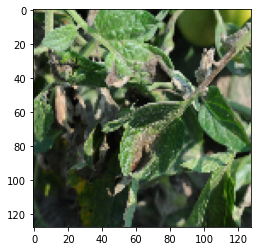

In [8]:
plt.imshow(trainx[345])
print(trainy[345])
plt.show()

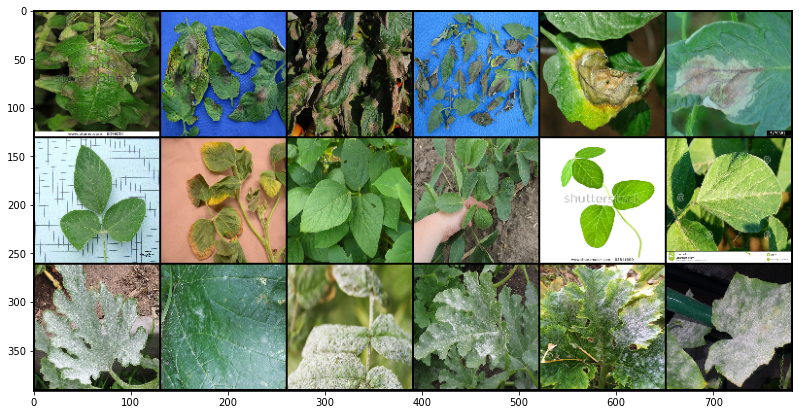

In [9]:
sample_example = extract_sample(3, 1, 5, trainx, trainy)
display_sample(sample_example['images'])

In [10]:
import torchvision.transforms as T

class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']
    
    def aug_layer():
        return nn.Sequential(
        T.RandomHorizontalFlip(0.5),
        T.RandomRotation(45),
        T.RandomVerticalFlip(0.5)
        )
    def conv_block1(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 11),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
    def conv_block2(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 5),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
    def conv_block3(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,padding =1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

    encoder = nn.Sequential(
        conv_block1(x_dim[0], hid_dim),
        conv_block2(hid_dim, hid_dim),
        conv_block3(hid_dim, hid_dim),
        conv_block3(hid_dim, z_dim),
        Flatten(),
        )

    return ProtoNet(encoder)

In [11]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [12]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }
  def set_forward_loss_RNNP(self, sample):
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
    
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
    
    z = self.encoder.forward(x)
    
    z_dim = z.size(-1) #usually 64
    z_support = z[:n_way*n_support];
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]
    beta=10
    alpha=0.7
    if(n_support*(n_support-1)/2 >= beta):
        z_hybrid=[]
        for classes in range(n_way):
            z_class=z[classes*n_support:classes*n_support+(n_support)]
            pairs=list(itertools.combinations(z_class,2))
            selected_support=random.sample(pairs,beta)
            for i in selected_support:
                hybrid=alpha*i[0]+(1-alpha)*i[1]
                hybrid_np=hybrid.detach().cpu().numpy()
                z_hybrid.append(hybrid_np)
    
        z_hybrid_np=np.array(z_hybrid)
        z_hybrid_tensor=torch.from_numpy(z_hybrid_np)
        zh_cuda1=z_hybrid_tensor.to("cuda:1")
        all_pt = torch.cat((z,zh_cuda1),0)
        all_pt_np=all_pt.detach().cpu().numpy()
        kmeans = KMeans(n_clusters=n_way, init=z_proto.detach().cpu().numpy(),n_init=1).fit(all_pt_np)
        new_centers=torch.from_numpy(kmeans.cluster_centers_)
        new_centers_cuda=new_centers.to("cuda:1")
        dists = euclidean_dist(z_query, new_centers_cuda)
    else:
        print("Not doing RNNP")
        dists = euclidean_dist(z_query, z_proto)
    
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

TRAINING

In [13]:
val_loss=[]

In [17]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        print(episode)
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    val_loss.append(avg_loss)
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [18]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far
    stop = False #status to know when to stop
    loss_arr=[]
    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0
        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            instant_loss=output['loss']
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        loss_arr.append(epoch_loss)
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        # with torch.no_grad():
        #     test(model,clean_testx,clean_testy,n_way,n_support,n_query,epoch_size)
        epoch += 1
        scheduler.step()
    epoch_arr=np.linspace(1,max_epoch,max_epoch)
    plt.plot(epoch_arr,loss_arr)
    #plt.plot(epoch_arr,val_loss)
    plt.show()

/tmp/ipykernel_12699/3982964401.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 2.3270 Acc: 0.3913


Epoch 2 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 1.1538 Acc: 0.5260


Epoch 3 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.8823 Acc: 0.6537


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.5494 Acc: 0.7916


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.3742 Acc: 0.8597


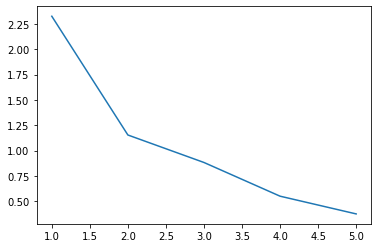

CPU times: user 1h 24min 44s, sys: 2min 25s, total: 1h 27min 9s
Wall time: 21min 47s


In [27]:
%%time

model = load_protonet_conv(x_dim=(3,128,128),hid_dim=32,z_dim=32)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 5
n_support = 10
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size) 

In [22]:
torch.save(model.state_dict(),"./model.pth")

In [23]:
model = load_protonet_conv(
    x_dim=(3,128,128),
    hid_dim=32,
    z_dim=32,
    )
model.load_state_dict(torch.load("./model.pth"))
model.eval()

ProtoNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [28]:
with torch.no_grad():
    n_way = 5
    n_support = 10
    n_query = 5

    test_episode = 1000

    test(model, clean_testx, clean_testy, n_way, n_support, n_query, test_episode)

/tmp/ipykernel_12699/2741228981.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/1000 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27